In [31]:
import rasterio
import numpy as np
import cv2
import numpy as numpy
import matplotlib.pyplot as plt
from osgeo import gdal
import argparse

# %matplotlib inline

# # import xarray as xr
# import numpy as np
# import geopandas as gpd
import scipy
# import matplotlib.pyplot as plt
from osgeo import gdal
# from datacube.utils.cog import write_cog
# from datacube.utils.geometry import Geometry
from skimage.segmentation import quickshift
import rasterio
from skimage.segmentation import felzenszwalb
from skimage import img_as_float
import numpy as np
import matplotlib.pyplot as plt
# from deafrica_tools.plotting import display_map
# from deafrica_tools.areaofinterest import define_area
# from deafrica_tools.bandindices import calculate_indices
# from deafrica_tools.datahandling import load_ard, mostcommon_crs, array_to_geotiff

In [32]:
pixel_vals  = gdal.Open(r'E:\wenqu\segmentationn\tasseled_cap_greeness\MASKED\site7_TP.tif').ReadAsArray().astype(np.float64)

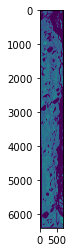

In [33]:

plt.imshow(pixel_vals)

In [3]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
from skimage.segmentation import quickshift
import numpy as np

# Load the single-band image
image_path = r'E:\wenqu\segmentationn\tasseled_cap_greeness\MASKED\site7_TP.tif'   # Update this with your image path
with rasterio.open(image_path) as src:
    image = src.read(1)  # Read the first band
    affine = src.transform

# Perform segmentation
segments = quickshift(image, kernel_size=3, max_dist=6, ratio=0.5, convert2lab=False)

# Mask to separate each segment
mask = segments != -1  # Assuming -1 is used for background or no data

# Raster to Vector Conversion
results = ({'properties': {'raster_val': v}, 'geometry': s}
           for i, (s, v) in enumerate(
               shapes(segments.astype(np.int16), mask=mask, transform=affine)))

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(list(results))

# Save to a shapefile
output_shapefile = r'E:\wenqu\segmentationn\segmented_image_polygons.shp'  # Define your output path
gdf.to_file(output_shapefile)


C:\Users\laral\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


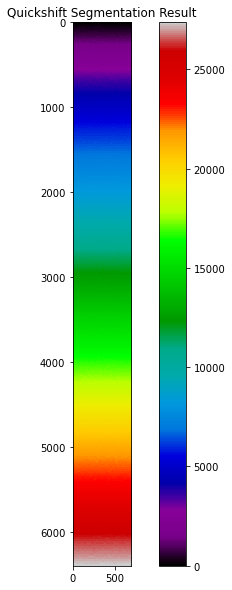

In [2]:
import rasterio
from skimage.segmentation import quickshift
import matplotlib.pyplot as plt

# Load the single-band image
image_path = r'E:\wenqu\segmentationn\tasseled_cap_greeness\MASKED\site7_TP.tif'  # Update this with your image path
with rasterio.open(image_path) as src:
    image = src.read(1)  # Read the first band

# Apply Quickshift segmentation
segments = quickshift(image, kernel_size=3, max_dist=6, ratio=0.5, convert2lab=False)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(segments, cmap='nipy_spectral')
plt.title('Quickshift Segmentation Result')
plt.colorbar()
plt.show()


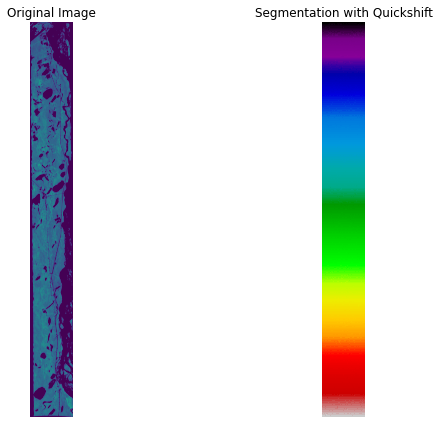

In [36]:
import rasterio
from skimage.segmentation import quickshift
import matplotlib.pyplot as plt
import numpy as np

def read_image(file_path):
    """Read an image and return it as a numpy array."""
    with rasterio.open(file_path) as src:
        image = src.read()
        # For RGB images, ensure ordering is correct (height, width, bands)
        if image.shape[0] == 3:  # Assuming the first dimension is bands for RGB
            image = np.transpose(image, (1, 2, 0))
    return image

def segment_image_quickshift(image, kernel_size=3, max_dist=6, ratio=0.5, convert2lab=False):
    """Segment an image using Quickshift without converting to Lab space."""
    segments = quickshift(image, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio, convert2lab=convert2lab)
    return segments


def plot_segmentation(image, segments):
    """Plot the original image and its segmentation."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[1].imshow(segments, cmap='nipy_spectral')
    axes[1].set_title('Segmentation with Quickshift')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Specify the path to your image file
image_path = r'E:\wenqu\segmentationn\tasseled_cap_greeness\MASKED\site7_TP.tif'

# Read the image
image = read_image(image_path)
image = image.squeeze()
# Segment the image
segments = segment_image_quickshift(image)

# Plot the original image and its segmentation
plot_segmentation(image, segments)


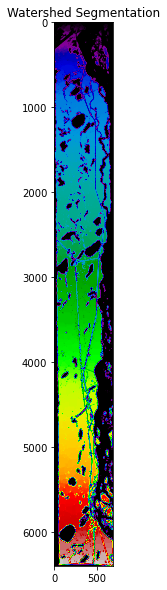

In [1]:
import cv2
import numpy as np
import rasterio
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import matplotlib.pyplot as plt

# Load the single-band image
image_path = r'E:\wenqu\segmentationn\tasseled_cap_greeness\MASKED\site7_TP.tif'
with rasterio.open(image_path) as src:
    image = src.read(1)

# Convert to 8-bit (if necessary)
image = (image / np.max(image) * 255).astype('uint8')

# Apply a threshold to obtain a binary image
_, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Compute the distance transform
distance = ndimage.distance_transform_edt(binary)

# Identify local maxima
local_maxi = peak_local_max(distance, footprint=np.ones((5, 5)), labels=binary)

# Convert local_maxi to a boolean array if it's not already
if not isinstance(local_maxi, np.ndarray) or local_maxi.dtype != bool:
    maxima_boolean = np.zeros_like(distance, dtype=bool)
    maxima_boolean[tuple(local_maxi.T)] = True
else:
    maxima_boolean = local_maxi

# Label the local maxima
markers, _ = ndimage.label(maxima_boolean)

# Apply Watershed
labels = watershed(-distance, markers, mask=binary)

# Visualization
plt.figure(figsize=(10, 10))
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Watershed Segmentation')
plt.show()


In [4]:
import geopandas as gpd
from shapely.geometry import shape
import rasterio
from rasterio.features import shapes
import numpy as np

# Load the original raster image to get its transform and CRS
# image_path = 'path_to_your_single_band_image.tif'
with rasterio.open(image_path) as src:
    transform = src.transform
    crs = src.crs

# Assuming 'labels' contains the result from the Watershed segmentation

# Convert the segmented image to shapes (polygons)
mask = labels > 0  # Assuming 0 is the background or non-segmented label

# Extract polygons and values from the labeled matrix
polygons = shapes(labels.astype(np.int16), mask=mask, transform=transform)

# Prepare a list for storing geometry data
geometry_list = []

for polygon, value in polygons:
    # Convert the polygon shapes to Shapely geometry
    geom = shape(polygon)
    geometry_list.append(geom)

# Create a GeoDataFrame from the list of geometries
gdf = gpd.GeoDataFrame(geometry=geometry_list)

# Set the coordinate reference system (CRS) of the GeoDataFrame from the raster
gdf.crs = crs

# Write the GeoDataFrame to a shapefile
output_shapefile = r'E:\wenqu\segmentationn\watershed_segments.shp'
gdf.to_file(output_shapefile)

print(f'Shapefile saved to {output_shapefile}')



Shapefile saved to E:\wenqu\segmentationn\watershed_segments.shp


In [9]:
segments = felzenszwalb(pixel_vals, scale=100, sigma=0.5, min_size=50)

NameError: name 'felzenszwalb' is not defined

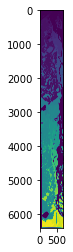

In [8]:
plt.imshow(segments)

In [27]:
import rasterio

# Load the original image with rasterio to get metadata
with rasterio.open(r'E:\wenqu\segmentationn\tasseled_cap_greeness\MASKED\site7_TP.tif') as src:
    profile = src.profile

# Update the metadata for the grayscale image
profile.update(dtype=rasterio.uint8, count=1,  nodata=None)

# Save the grayscale image with the same reference system
output_path = r'E:\wenqu\segmentationn\segments_zonal_mean_qs.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(segments_zonal_mean_qs, 1)

In [20]:
# image = np.transpose(pixel_vals, (1, 2, 0))
convert2lab=False
segments1 = quickshift(pixel_vals, kernel_size=3, max_dist=2, ratio=1, convert2lab=convert2lab)

In [28]:
segments_zonal_mean_qs.shape

(6396, 693)

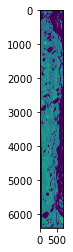

In [26]:
plt.imshow(segments_zonal_mean_qs)

In [25]:
# Calculate the zonal mean NDVI across the segments
segments_zonal_mean_qs = scipy.ndimage.mean(input=pixel_vals,
                                            labels=segments1,
                                            index=segments1)

In [14]:
segments = quickshift(pixel_vals,
                      kernel_size=1,
                      convert2lab=False,
                      max_dist=2,
                      ratio=1.0)

In [15]:
segments_zonal_mean_qs = scipy.ndimage.mean(input=pixel_vals,
                                            labels=segments,
                                            index=segments)

In [29]:
import numpy as np

# Assuming segments_zonal_mean_qs is a NumPy array
# This could be a grayscale image (2D array) or a colored image (3D array)

# Check if all values in the array are 0 (which would mean the image is totally black)
is_totally_black = np.all(segments_zonal_mean_qs == 0)

print("Is the segments_zonal_mean_qs totally black?", is_totally_black)


Is the segments_zonal_mean_qs totally black? False


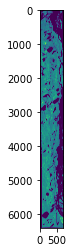

In [21]:
plt.imshow(segments_zonal_mean_qs)

In [7]:
import rasterio

# Path to the existing file from which to copy the transform and CRS
input_file_path = r'E:\wenqu\segmentationn\tasseled_cap_greeness\MASKED\site7_TP.tif'

# Path to the new file
output_file_path = r'E:\wenqu\segmentationn\labels.tif'

# Open the existing file to read its spatial metadata
with rasterio.open(input_file_path) as src:
    # Extract the metadata from the source file
    out_meta = src.meta.copy()

# Update the metadata for the new file based on your array's properties
# Assume segments_zonal_mean_qs is your array to be saved
out_meta.update({
    'dtype': 'float32',  # Make sure to set this to the dtype of your segments_zonal_mean_qs array
    'count': 1,  # Set the number of bands in your output file; adjust if necessary
    'height': labels.shape[0],
    'width': labels.shape[1],
    # 'nodata': None, # Uncomment and set this if your array has a specific nodata value
})

# Write the array to a new TIFF file using the copied+updated metadata
with rasterio.open(output_file_path, 'w', **out_meta) as dst:
    dst.write(labels, 1)  # Writing your array as the first band


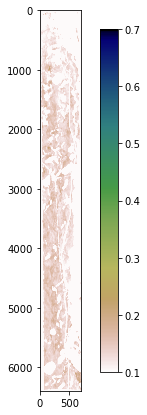

In [16]:
# Plot to see result
plt.figure(figsize=(7,7))
plt.imshow(segments_zonal_mean_qs, cmap='gist_earth_r', vmin=0.1, vmax=0.7)
plt.colorbar(shrink=0.9)

In [19]:
segments_zonal_mean_qs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
import rasterio

# Load the original image with rasterio to get metadata
with rasterio.open(r'E:\wenqu\segmentationn\tasseled_cap_greeness\MASKED\site7_TP.tif') as src:
    profile = src.profile

# Update the metadata for the grayscale image
profile.update(dtype=rasterio.uint8, count=1,  nodata=None)

# Save the grayscale image with the same reference system
output_path = r'E:\wenqu\segmentationn\segments_zonal_mean_qs.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(segments_zonal_mean_qs, 1)

In [20]:
transform = ds.geobox.transform.to_gdal()
projection = ds.geobox.crs.wkt

# Export the array
array_to_geotiff(r'E:\wenqu\segmentationn\segments_zonal_mean_qs1.tif',
                  segments_zonal_mean_qs,
                  geo_transform=transform,
                  projection=projection,
                  nodata_val=np.nan)

NameError: name 'ds' is not defined

In [5]:
gX = cv2.Sobel(dataset, cv2.CV_64F, 1, 0)
gY = cv2.Sobel(dataset, cv2.CV_64F, 0, 1)
# compute the gradient magnitude and orientation
magnitude = np.sqrt((gX ** 2) + (gY ** 2))
orientation = np.arctan2(gY, gX) * (180 / np.pi) % 180

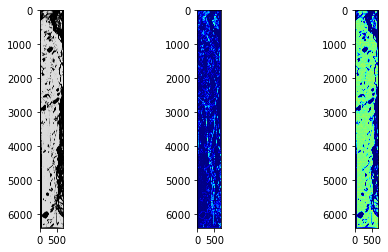

In [6]:
(fig, axs) = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
# plot each of the images
axs[0].imshow(dataset, cmap="gray")
axs[1].imshow(magnitude, cmap="jet")
axs[2].imshow(orientation, cmap="jet")

In [3]:
# Gaussian Blurring
blur = cv2.GaussianBlur(dataset,(5,5),0)

In [4]:
# Apply Sobelx in high output datatype 'float32'
# and then converting back to 8-bit to prevent overflow
sobelx_64 = cv2.Sobel(blur,cv2.CV_32F,1,0,ksize=3)
absx_64 = np.absolute(sobelx_64)
sobelx_8u1 = absx_64/absx_64.max()*255
sobelx_8u = np.uint8(sobelx_8u1)
 
# Similarly for Sobely
sobely_64 = cv2.Sobel(blur,cv2.CV_32F,0,1,ksize=3)
absy_64 = np.absolute(sobely_64)
sobely_8u1 = absy_64/absy_64.max()*255
sobely_8u = np.uint8(sobely_8u1)
 
# From gradients calculate the magnitude and changing
# it to 8-bit (Optional)
mag = np.hypot(sobelx_8u, sobely_8u)
mag = mag/mag.max()*255
mag = np.uint8(mag)
 
# Find the direction and change it to degree
theta = np.arctan2(sobely_64, sobelx_64)
angle = np.rad2deg(theta)

In [7]:
# Find the neighbouring pixels (b,c) in the rounded gradient direction
# and then apply non-max suppression
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.uint8)
 
for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Non-max Suppression
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
        else:
            Non_max[i,j] = 0

In [8]:
# Set high and low threshold
highThreshold = 21
lowThreshold = 15
 
M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.uint8)
 
# If edge intensity is greater than 'High' it is a sure-edge
# below 'low' threshold, it is a sure non-edge
strong_i, strong_j = np.where(Non_max >= highThreshold)
zeros_i, zeros_j = np.where(Non_max < lowThreshold)
 
# weak edges
weak_i, weak_j = np.where((Non_max <= highThreshold) & (Non_max >= lowThreshold))
 
# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

In [9]:

M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

In [10]:
out

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [18]:
from osgeo import gdal,ogr,osr
high_res_img = gdal.Open(r'E:\wenqu\aviris\arctic_region\masked_aviris_trait\site7_sla_ymax.tif')
pj = high_res_img.GetProjection()  ## projection
gt = high_res_img.GetGeoTransform()  ## geotransform
col = high_res_img.GetRasterBand(1).XSize
row = high_res_img.GetRasterBand(1).YSize

In [19]:
import os

driver = gdal.GetDriverByName('GTiff')  ## driver for output file type; "GTiff" for geotiff, "RST" for rst
bands =1
outName = "segmented_image.tif"
outPath =r'E:\wenqu\segmentationn'
out_ds = driver.Create(os.path.join(outPath, outName),col,row,bands,gdal.GDT_Float32)

In [20]:
out_ds.GetRasterBand(1).WriteArray(segmented_image)
out_ds.SetProjection(pj)
out_ds.SetGeoTransform(gt)
del out_ds